In [ ]:
%%capture
! pip install pmdarima
! pip install fbprophet
! pip install catboost

In [ ]:
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from pmdarima import auto_arima # Поиск подходящих параметров для модели ARIMA
import warnings
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from prophet import Prophet
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import seaborn as sns
from catboost import CatBoostRegressor
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

In [ ]:
def stationary_test(data): # проверка на стационарность
  adf_result = adfuller(data)
  print(f"ADF Statistic: {adf_result[0]}")
  print(f"p-value: {adf_result[1]}")
  print('Critical Values:')
  for key, value in adf_result[4].items():
      print('\t%s: %.3f' % (key, value))
  if (adf_result[4]['5%'] > adf_result[0]):
          print("\u001b[32mStationary\u001b[0m")
  else:
      print("\x1b[31mNon-stationary\x1b[0m")

In [ ]:
def metrics(y, predictions): # подсчет метрик
    print('R2:', r2_score(y, predictions))
    print('MAPE:', mean_absolute_percentage_error(y, predictions))
    print('RMSE:', (mean_squared_error(y, predictions))**0.5)
    print('MAE: ', mean_absolute_error(y, predictions))

In [ ]:
def plotting_comparison(predictions, title = 'XGB', y_true = False): # графики предсказаний
    if not isinstance(predictions, bool):
      test_y = y_true
    plt.gcf().set_size_inches(10, 7)
    plt.plot(predictions, label = 'predictions')
    plt.plot(test_y, label = 'true value')
    plt.legend(loc='upper left')
    plt.title(title + ' model')
    plt.show()

In [ ]:
def add_lags(df, target_cols): # добавление лагов
    dataframe = df.copy()
    for target_col in target_cols:
      dataframe[f'{target_col}_lag_1_year_mean'] = dataframe[target_col].rolling(365).mean().shift(1).fillna(0)
      dataframe[f'{target_col}_lag_1_year'] = dataframe[target_col].shift(365).fillna(0)
      dataframe[f'std_{target_col}_7_days'] = dataframe[target_col].rolling(7).std().shift(1).fillna(0)
      dataframe[f'std_{target_col}_1_month'] = dataframe[target_col].rolling(31).std().shift(1).fillna(0)
      dataframe[f'std_{target_col}_3_months'] = dataframe[target_col].rolling(90).std().shift(1).fillna(0)
      dataframe[f'std_{target_col}_6_months'] = dataframe[target_col].rolling(180).std().shift(1).fillna(0)
      dataframe[f'std_{target_col}_1_year'] = dataframe[target_col].rolling(365).std().shift(1).fillna(0)
      dataframe[f'jump_{target_col}_1_month'] = dataframe[target_col].diff().abs().rolling(31).max().shift(1).fillna(0)
      dataframe[f'jump_{target_col}_3_months'] = dataframe[target_col].diff().abs().rolling(90).max().shift(1).fillna(0)
      dataframe[f'jump_{target_col}_6_months'] = dataframe[target_col].diff().abs().rolling(180).max().shift(1).fillna(0)
      dataframe[f'jump_{target_col}_1_year'] = dataframe[target_col].diff().abs().rolling(365).max().shift(1).fillna(0)
      dataframe[f'jump_{target_col}_1_year_mean'] = dataframe[target_col].diff().abs().rolling(365).mean().shift(1).fillna(0)
      df[f'Lastday_{target_col}'] = df[target_col].shift(+1) # Подготовка данных для Random Forest
      df[f'Last_2_days_{target_col}'] = df[target_col].shift(+2)
    return dataframe

In [ ]:
def add_time_features(df): # добавление временных фичей
    df['dayofweek'] = df.date.dt.dayofweek
    df['quarter'] = df.date.dt.quarter
    df['month'] = df.date.dt.month
    df['year'] = df.date.dt.year
    df['dayofyear'] = df.date.dt.dayofyear
    return df

In [ ]:
all_files = ["SGE Gold.csv", "wheat_y.csv", "Нефть.csv", "Соевая мука.csv"]

In [ ]:
def preprocess(filename = "wheat_y.csv"): # предобработка csv файлов
  df = pd.read_csv(filename)
  filename = filename.replace(".csv", "")
  df = df[::-1].reset_index(drop = True)
  df.Дата = pd.to_datetime(df.Дата, dayfirst=True)
  df.iloc[:, 1:5] = df.iloc[:, 1:5].apply(lambda x: x.str.replace(",", "."))
  df[df.columns[1:5]] = df.iloc[:, 1:5].astype(float)
  df.rename({"Цена": "price", "Дата": "date"}, axis=1, inplace = True)
  df["Объём"] = df["Объём"].fillna('0K').apply(lambda x: x.replace(",", ".")[:-1]).astype(float)
  df["Объём"] = df["Объём"].replace(0, df["Объём"].mean())
  df["Изм. %"] = df["Изм. %"].apply(lambda x: float(x.replace(",", ".")[:-1])).shift(1).fillna(0)
  df = df.add_prefix(f"{filename}_")
  df.rename({f"{filename}_date": "date"}, axis=1, inplace = True)

  if filename == "wheat_y":
    df.rename({f"{filename}_price": "price"}, axis = 1, inplace = True)
  return df

In [ ]:
df_y = preprocess()
df_y.index = df_y.date
df_y = add_lags(df_y, df_y.columns[1:])
df_y = add_time_features(df_y)

In [ ]:
dataframes = []
for filename in all_files[:-1]:
  dataframes.append(preprocess(filename))

merged_df = dataframes[0]

for df in dataframes[1:]:
  merged_df = merged_df.merge(df, on='date', how='inner')
df = merged_df
col = df.pop("price")
df.insert(df.shape[1], col.name, col)
df = df[::-1].reset_index(drop = True)
df.index = df.date

Проверка на корреляцию предикторов (временных рядов) с признаками

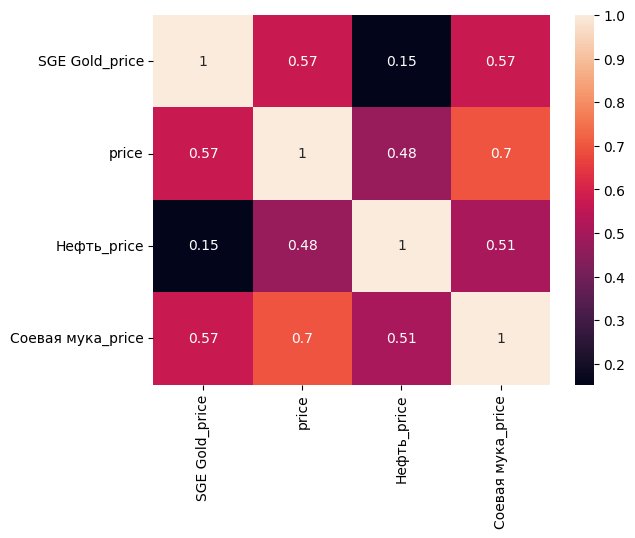

In [ ]:
sns.heatmap(df[df.columns[df.columns.str.contains("price")]].corr(), annot=True)
plt.show()

In [ ]:
df = add_lags(df, df.columns[1:])
df = add_time_features(df)

In [ ]:
df.price.describe()

,price
count,4523.000000
mean,196.955726
std,54.640743
min,103.500000
25%,161.750000
50%,189.750000
75%,223.000000
max,438.250000


In [ ]:
df.isna().sum().sum()

0

In [ ]:
df.groupby(df.quarter).price.mean()

,price
quarter,
1,199.660240
2,194.548459
3,193.322869
4,198.607315


Декомпозиция с сезонностью 365

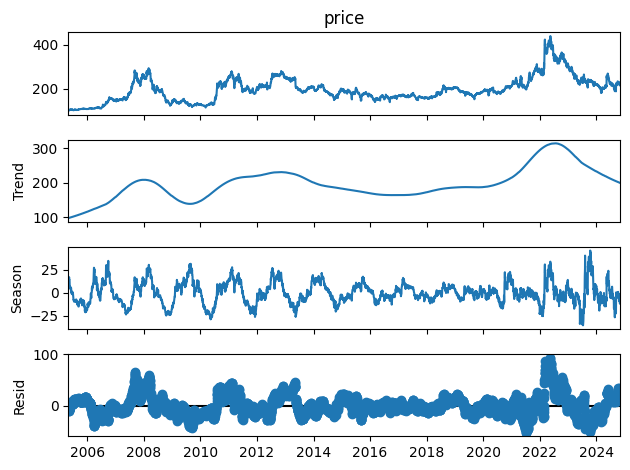

In [ ]:
stl = STL(df.price, period=365)
res = stl.fit()
fig = res.plot()

Декомпозиция по неделям

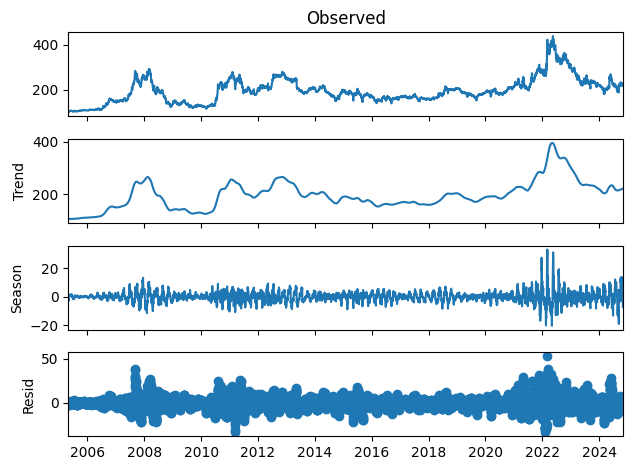

In [ ]:
stl = STL(df.drop("date", axis=1), period=52)
res = stl.fit()
fig = res.plot()

Декомпозиция по месяцам

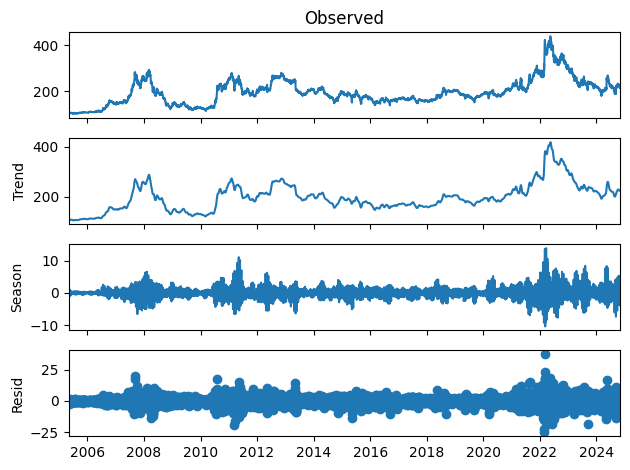

In [ ]:
stl = STL(df.drop("date", axis=1), period=12)
res = stl.fit()
fig = res.plot()

Декомпозиция по кварталам

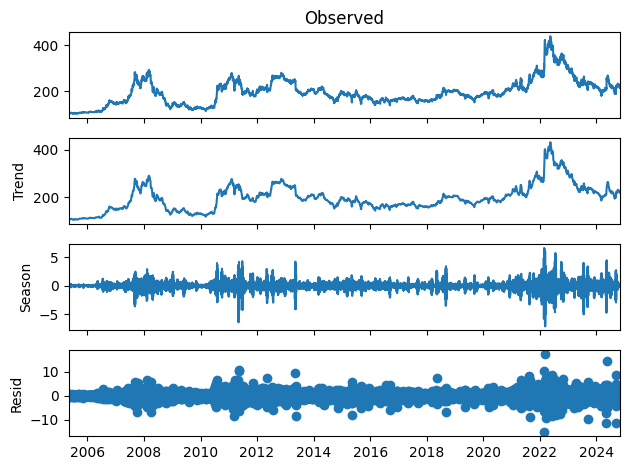

In [ ]:
from statsmodels.tsa.seasonal import STL

stl = STL(df.drop("date", axis=1), period=3)
res = stl.fit()
fig = res.plot()

Есть сильная годичная и квартальная сезонность, тренд присуствует (Сначала наблюдался общий рост до 2008 года, затем падение, и новый рост после 2020 года)

Проверка на автокорреляцию

In [ ]:
from statsmodels.stats.stattools import durbin_watson
durbin_watson(df.price)

0.00033278228169357027

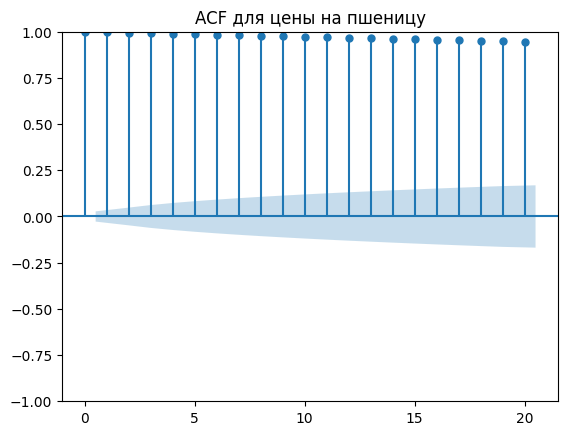

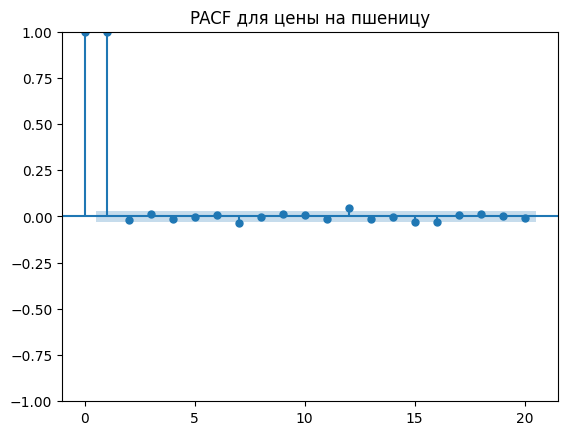

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF и PACF графики
plot_acf(df.price, lags=20)
plt.title('ACF для цены на пшеницу')
plt.show()

plot_pacf(df.price, lags=20)
plt.title('PACF для цены на пшеницу')
plt.show()

In [ ]:
stationary_test(df.price)

ADF Statistic: -2.8063613661281632
p-value: 0.05737082195900103
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Non-stationary


Проверка на автокорреляцию первой разности ряда

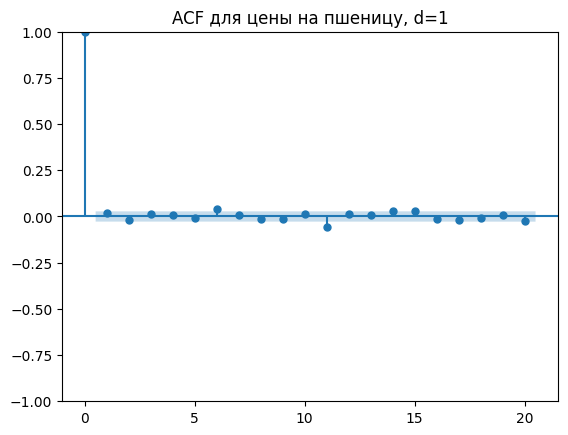

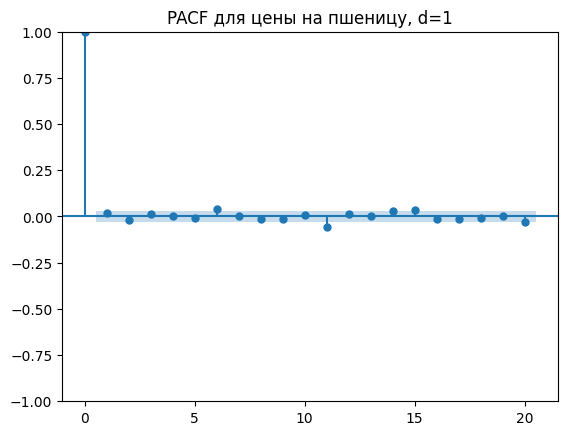

In [ ]:
plot_acf(df.price.diff().fillna(0), lags=20)
plt.title('ACF для цены на пшеницу, d=1')
plt.show()

plot_pacf(df.price.diff().fillna(0), lags=20)
plt.title('PACF для цены на пшеницу, d=1')
plt.show()

In [ ]:
stationary_test(df.price.diff().fillna(0))

ADF Statistic: -17.41084309972436
p-value: 4.8868866463259834e-30
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Stationary


При вычитании из ряда первой разности он становится стационарным (параметр p - 1)

**Модель RandomForest**

In [ ]:
split_date = pd.to_datetime("2024-07-01")
split_date_train = pd.to_datetime("2015-08-01")
#split_date_train = pd.to_datetime("2000-01-01")
train, test = df[(df.date > split_date_train) & (df.date < split_date)], df[df.date > split_date]
X_start_index = df.columns.tolist().index("price")+1
exogenous_features = df.columns[X_start_index:].tolist()
test_y, test_x = test[['price']].values, test.loc[:, exogenous_features].values
train_y, train_x = train[['price']].values, train.loc[:, exogenous_features].values

In [ ]:
forest = RandomForestRegressor(n_estimators = 30, max_features=10, max_depth=3)
forest.fit(train_x, train_y)
f_predictions = forest.predict(train_x)
print(metrics(train_y.flatten(), f_predictions))
f_predictions = forest.predict(test_x)
metrics(test_y.flatten(), f_predictions)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


R2: 0.8487569269470141
MAPE: 0.09553305582886745
RMSE: 21.409083517083932
MAE:  16.801762445590118
None
R2: -5.87735110664926
MAPE: 0.10948599407726625
RMSE: 27.07406518567016
MAE:  24.16521859389151


**Модель Catboost**

In [745]:
model = CatBoostRegressor(n_estimators=500,
                          learning_rate=0.06, max_depth=7,
                          allow_writing_files=False, eval_metric="RMSE", random_seed=0)

model.fit(
    train_x, train_y,
    eval_set=(test_x, test_y),
    verbose=50)

0:	learn: 55.4335780	test: 10.4962515	best: 10.4962515 (0)	total: 206ms	remaining: 1m 42s
50:	learn: 7.4381382	test: 22.8137029	best: 10.4305447 (3)	total: 5.72s	remaining: 50.4s
100:	learn: 4.6576804	test: 22.7498363	best: 10.4305447 (3)	total: 11.8s	remaining: 46.5s
150:	learn: 3.8627340	test: 21.8852684	best: 10.4305447 (3)	total: 16.5s	remaining: 38.2s
200:	learn: 3.2830294	test: 21.5802006	best: 10.4305447 (3)	total: 23.3s	remaining: 34.6s
250:	learn: 2.8541937	test: 21.8605432	best: 10.4305447 (3)	total: 28s	remaining: 27.8s
300:	learn: 2.5143906	test: 21.9196984	best: 10.4305447 (3)	total: 32.8s	remaining: 21.7s
350:	learn: 2.2271182	test: 21.9179754	best: 10.4305447 (3)	total: 39.4s	remaining: 16.7s
400:	learn: 2.0042993	test: 22.0455676	best: 10.4305447 (3)	total: 44.1s	remaining: 10.9s
450:	learn: 1.8463136	test: 22.0767413	best: 10.4305447 (3)	total: 50.1s	remaining: 5.44s
499:	learn: 1.6928752	test: 22.2216809	best: 10.4305447 (3)	total: 55.4s	remaining: 0us

bestTest = 10.

In [ ]:
predictions = model.predict(test_x)
metrics(test_y.flatten(), predictions)

R2: -0.0032679062184113317
MAPE: 0.039073693571534944
RMSE: 10.340733166674944
MAE:  8.266961736237425


In [ ]:
model = CatBoostRegressor(n_estimators=500,
                          learning_rate=0.099, max_depth=3,
                          allow_writing_files=False, eval_metric="RMSE", random_seed=0)

model.fit(
    train_x, train_y,
    eval_set=(test_x, test_y),
    verbose=50)

0:	learn: 51.2338624	test: 19.4225510	best: 19.4225510 (0)	total: 16.8ms	remaining: 8.4s
50:	learn: 10.1103809	test: 24.7476240	best: 15.7375661 (3)	total: 830ms	remaining: 7.31s
100:	learn: 7.3787459	test: 12.8251336	best: 12.8224525 (98)	total: 1.52s	remaining: 6.01s
150:	learn: 6.2623542	test: 10.1099158	best: 10.0414862 (144)	total: 2.31s	remaining: 5.33s
200:	learn: 5.4885225	test: 9.1113869	best: 9.1113869 (200)	total: 3.33s	remaining: 4.96s
250:	learn: 4.9550224	test: 8.3857789	best: 8.3123082 (246)	total: 4.12s	remaining: 4.08s
300:	learn: 4.5782855	test: 8.1804768	best: 8.1625516 (293)	total: 4.97s	remaining: 3.28s
350:	learn: 4.2902861	test: 7.9758185	best: 7.9741328 (349)	total: 5.86s	remaining: 2.48s
400:	learn: 4.0719662	test: 8.1611352	best: 7.9741328 (349)	total: 6.44s	remaining: 1.59s
450:	learn: 3.8722547	test: 8.2947822	best: 7.9741328 (349)	total: 6.84s	remaining: 743ms
499:	learn: 3.7145183	test: 8.3845771	best: 7.9741328 (349)	total: 7.22s	remaining: 0us

bestTest 

In [ ]:
predictions = model.predict(test_x)
metrics(test_y.flatten(), predictions)

R2: 0.40340284163239204
MAPE: 0.02715615014987092
RMSE: 7.974132763325368
MAE:  5.688167378679564


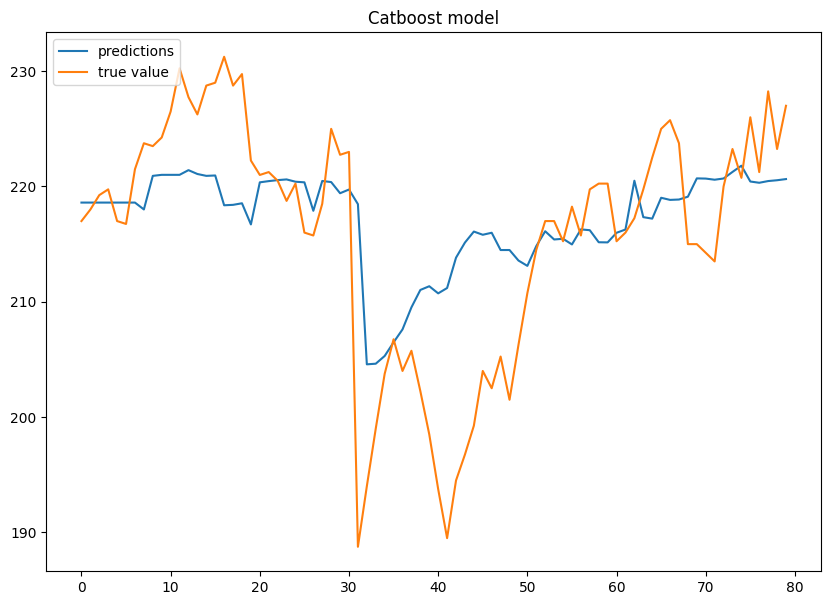

In [ ]:
plotting_comparison(predictions, y_true = test_y, title = "Catboost")

Text(0.5, 1.0, 'Feature Importance')

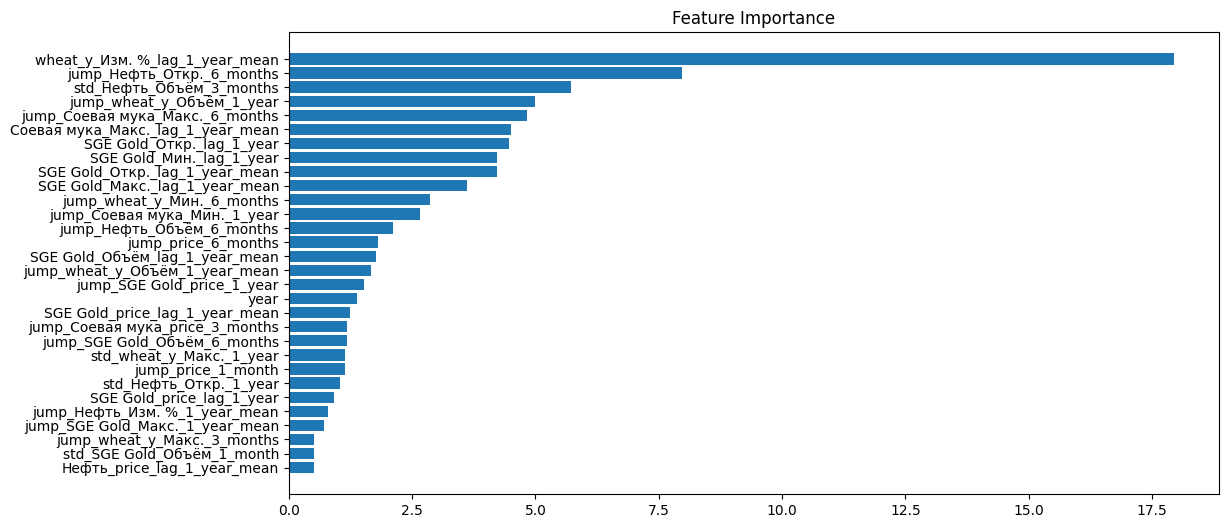

In [ ]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)[-30:]
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(exogenous_features)[sorted_idx])
plt.title('Feature Importance')

Text(0.5, 1.0, 'Feature Importance')

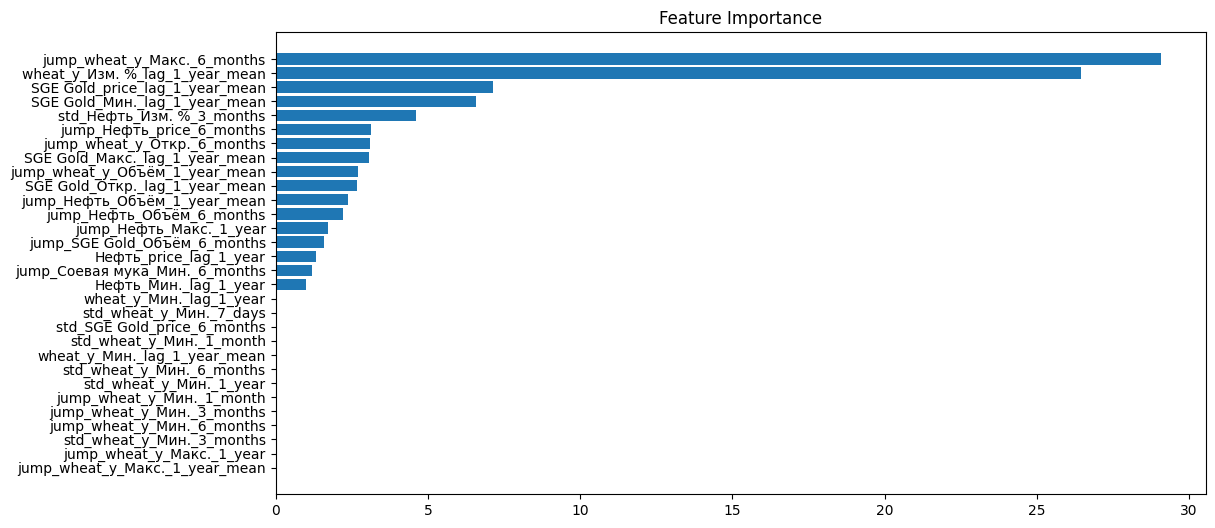

In [ ]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)[-30:]
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(exogenous_features)[sorted_idx])
plt.title('Feature Importance')

In [ ]:
predictions = regr_xgb.predict(test_x).flatten()
metrics(test_y.flatten(), predictions)

R2: 0.3750602024620703
MAPE: 0.03123479364056253
RMSE: 8.161349248707321
MAE:  6.636472892761231


In [ ]:
model = CatBoostRegressor(n_estimators=500,
                          learning_rate=0.099, max_bin=64, max_depth=3,
                          allow_writing_files=False, eval_metric="RMSE", random_seed=0)

model.fit(
    train_x, train_y,
    eval_set=(test_x, test_y),
    verbose=50)

**Модель Xgboost**

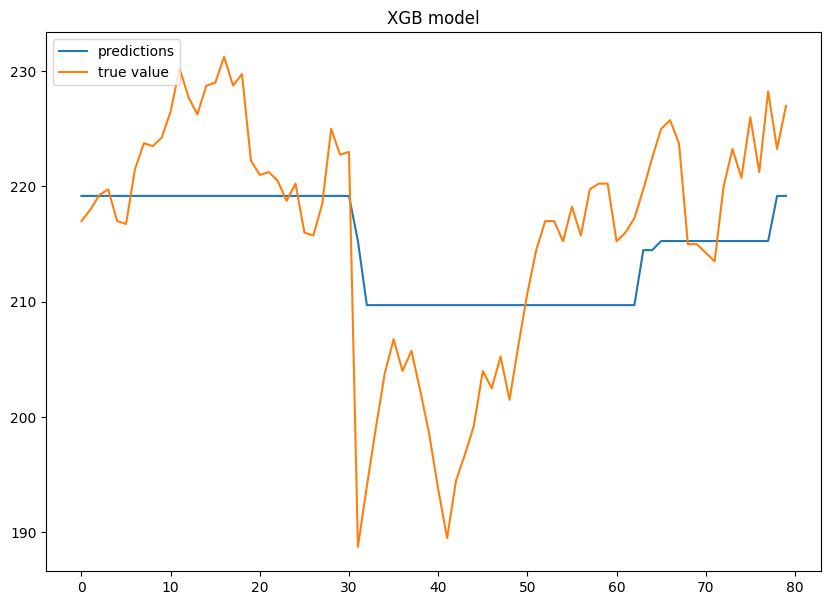

In [ ]:
plotting_comparison(predictions, y_true = test_y)

**Модель Xgboost**

In [ ]:
predictions = regr_xgb.predict(test_x).flatten()
metrics(test_y.flatten(), predictions)

R2: 0.311261620944595
MAPE: 0.03365197222535806
RMSE: 8.664650475525969
MAE:  7.3012220404121315


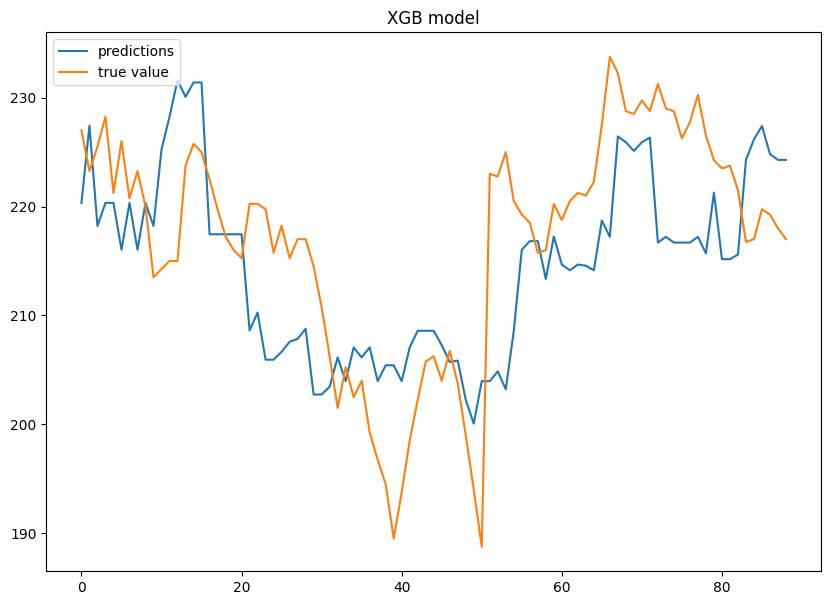

In [ ]:
plotting_comparison(predictions, y_true = test_y)

**Модель ARIMA**

In [ ]:
auto = auto_arima(train.price, exogenous=train[exogenous_features], trace=True, suppress_warnings = True)
auto.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=26750.510, Time=16.94 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=26762.624, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=26762.726, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=26762.654, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=26760.849, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=26764.621, Time=3.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=6.54 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=26766.887, Time=6.60 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=26752.364, Time=13.47 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=3.39 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=26764.900, Time=7.44 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=26764.893, Time=3.52 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=26753.572, Time=11.64 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=26748.733, Time=4.24 sec
 ARIMA(1,1,2)(0,0,0)[0]     

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4907
Model:               SARIMAX(2, 1, 2)   Log Likelihood              -13369.367
Date:                Wed, 06 Nov 2024   AIC                          26748.733
Time:                        15:04:26   BIC                          26781.224
Sample:                             0   HQIC                         26760.132
                               - 4907                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0031      0.028    -35.741      0.000      -1.058      -0.948
ar.L2         -0.9063      0.024    -37.114      0.000      -0.954      -0.858
ma.L1          1.0206      0.029     35.539      0.000       0.964       1.077
ma.L2          0.8977      0.025     35.822      0.000       0.849       0.947
sigma2        13.6313      0.084    161.338      0.000      13.466      13.797
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):             78612.31
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               2.09   Skew:                             0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
predictions = auto.predict(n_periods=len(test), exogenous = test[exogenous_features]).values

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
metrics(test_y, predictions)

R2: -0.7056596052966602
MAPE: 0.04751610578844585
RMSE: 13.48307821879718
MAE:  9.78784760586897


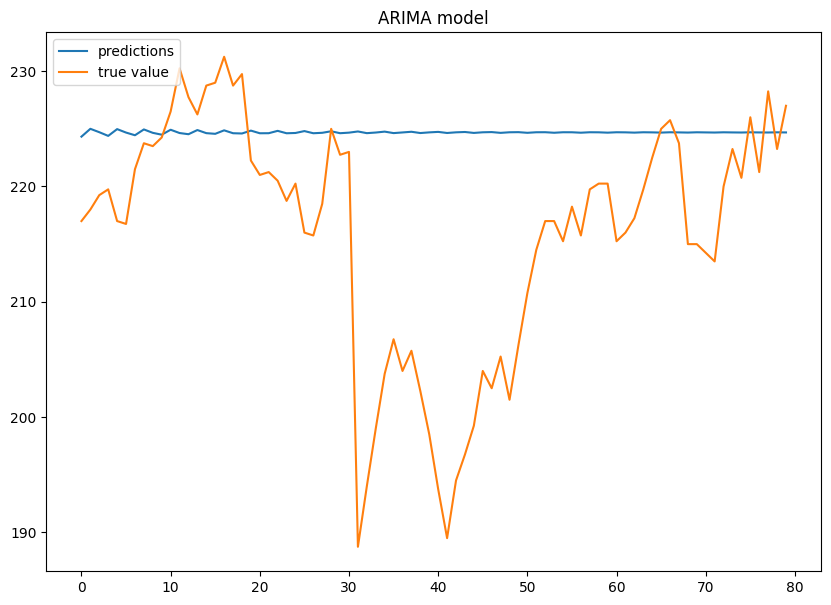

In [ ]:
plotting_comparison(predictions, title = 'ARIMA', y_true = test_y)

**Модель Prophet**

In [ ]:
%%time
df_prophet = df.rename({"date": "ds", "price": "y"}, axis = 1).reset_index(drop = True)
exog_prophet = exogenous_features + ["ds", "y"]
train_prophet = df_prophet.loc[df_prophet.ds < split_date, exog_prophet]
test_prophet = df_prophet.loc[df_prophet.ds > split_date, exog_prophet]


model_pr = Prophet(daily_seasonality=True, seasonality_mode='multiplicative')


for feature in exogenous_features:
	model_pr.add_regressor(feature)

model_pr.fit(train_prophet)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpvp5zsnb0/9j6wn71c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvp5zsnb0/10nv4oww.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69788', 'data', 'file=/tmp/tmpvp5zsnb0/9j6wn71c.json', 'init=/tmp/tmpvp5zsnb0/10nv4oww.json', 'output', 'file=/tmp/tmpvp5zsnb0/prophet_modelbg061rb4/prophet_model-20241106203855.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:38:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:39:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


CPU times: user 7.6 s, sys: 233 ms, total: 7.84 s
Wall time: 1min 1s


In [ ]:
predictions_pr = model_pr.predict(test_prophet)
metrics(test_y, predictions_pr.yhat)

/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1272: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['trend'] = self.predict_trend(df)


R2: -3.681927527395641
MAPE: 0.08632872542244494
RMSE: 22.338562124739628
MAE:  18.432484221806043


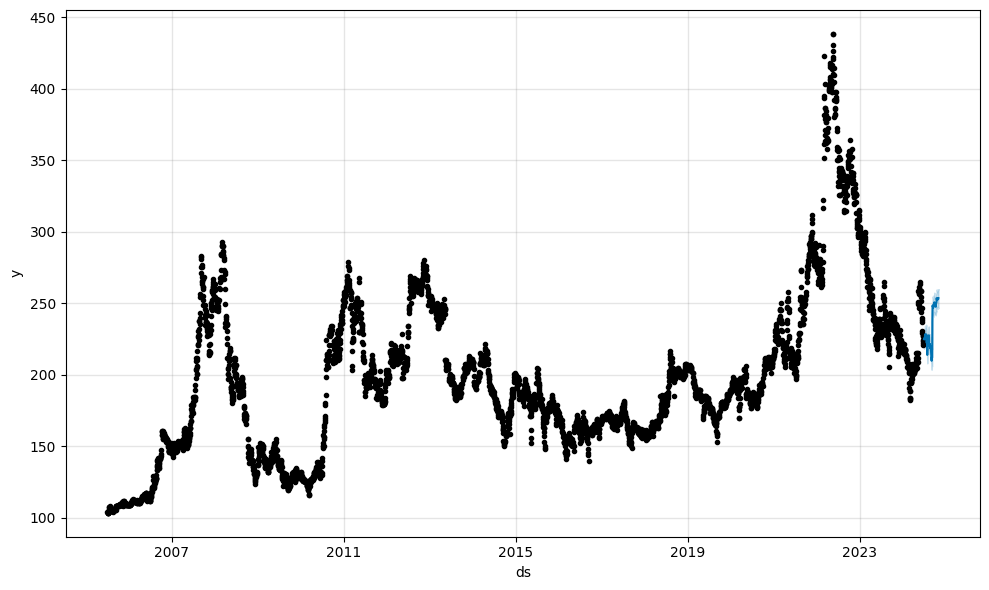

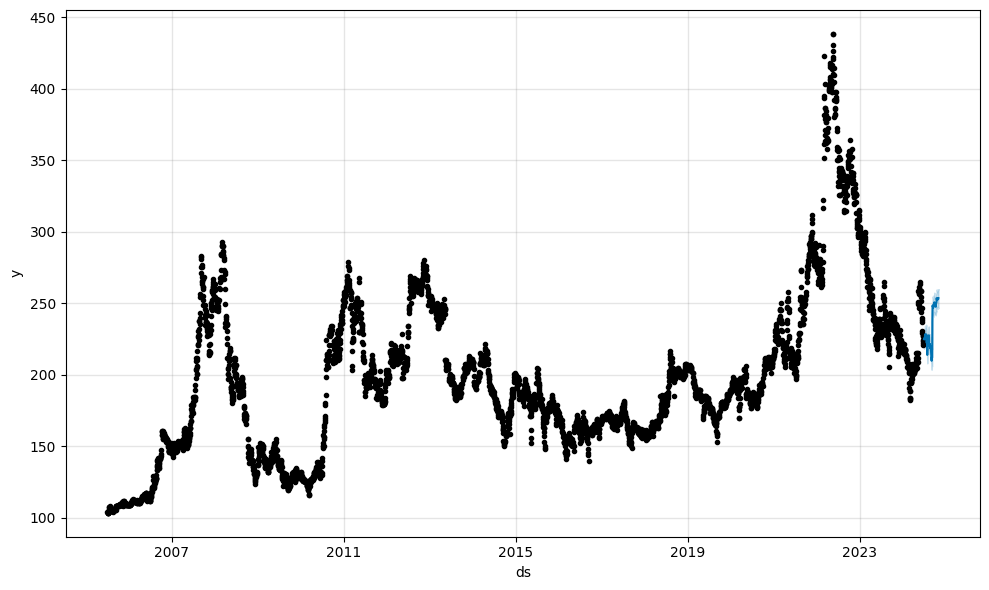

In [ ]:
model_pr.plot(predictions_pr)

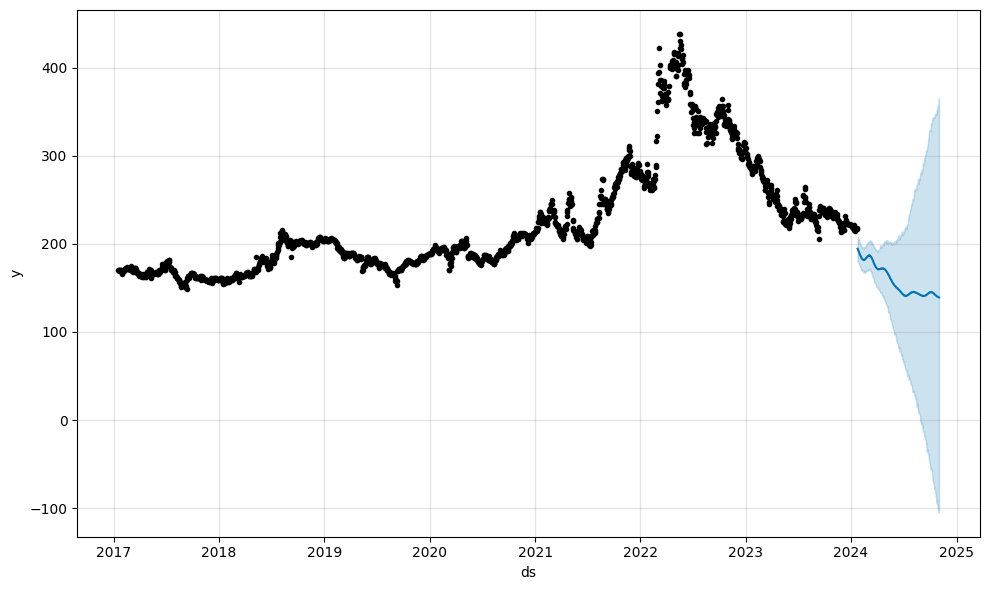

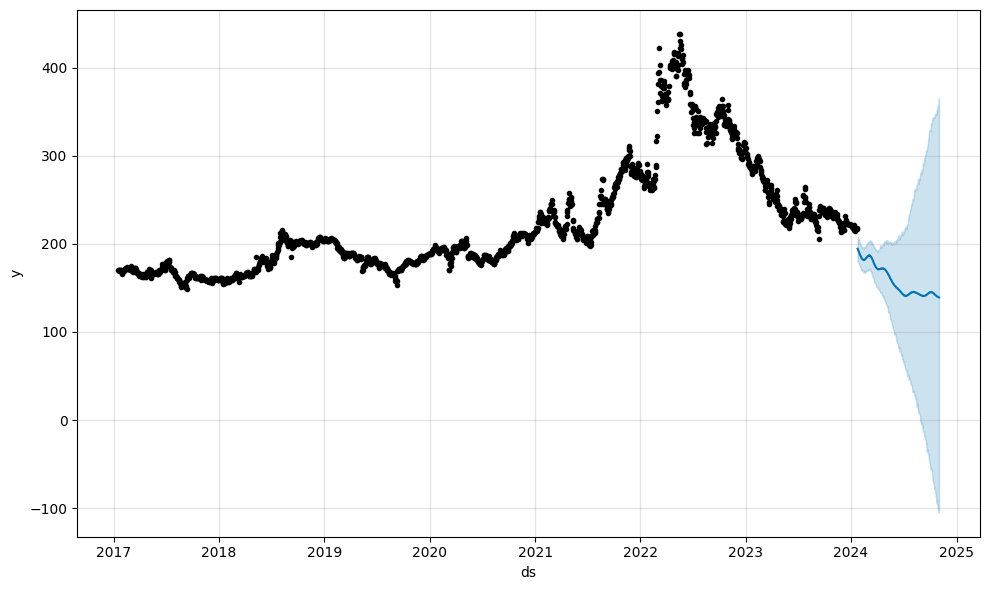

In [ ]:
model.plot(predictions)

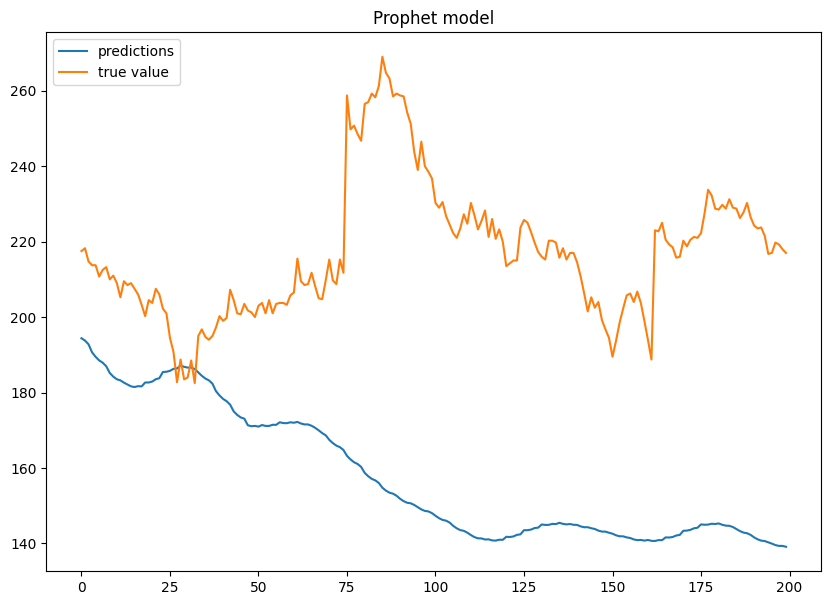

In [ ]:
plotting_comparison(predictions.yhat.values, title = 'Prophet', y_true = test_prophet.y.values)

In [ ]:
metrics(test_y, predictions.yhat.values)

R2 score: -5.762634366547938
MAPE: 0.13212150719498572
RMSE: 30.00043562558288
MAE:  27.762792300653363


Лучшая модель - Catboost

In [747]:
model.save_model("catboost_regressor")

In [ ]:
model_new = CatBoostRegressor()
model_new.load_model('catboost_regressor')

In [752]:
np.save('features.npy', np.array(exogenous_features))